# Analysis

**Hypothesis**: Severe COVID‐19 disrupts the normal co‐regulation between interferon response and antigen presentation. We hypothesize that the correlation between IFN1 (a proxy for interferon-stimulated gene expression) and HLA1 (an indicator of antigen presentation capacity) is significantly altered in COVID‐19 patients (Status = 1) compared to healthy controls (Status = 0) across various immune cell types. In addition, for subgroups with low cell counts, bootstrapping or permutation tests along with confidence intervals will be applied to ensure that the observed differences are statistically robust.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


Loading data...


Data loaded: 44721 cells and 26361 genes


# Analysis Plan

**Hypothesis**: Severe COVID‐19 disrupts the normal co‐regulation between interferon response and antigen presentation. We hypothesize that the correlation between IFN1 (a proxy for interferon-stimulated gene expression) and HLA1 (an indicator of antigen presentation capacity) is significantly altered in COVID‐19 patients (Status = 1) compared to healthy controls (Status = 0) across various immune cell types. In addition, for subgroups with low cell counts, bootstrapping or permutation tests along with confidence intervals will be applied to ensure that the observed differences are statistically robust.

## Steps:
1. Step 1: Validate and extract the relevant metadata from the in-memory anndata object. This includes checking that the required columns ('Status', 'cell_type_coarse', 'IFN1', and 'HLA1') are present, ensuring there are no NaN values in the key gene expression columns, and logging a summary of the cell count.
2. Step 2: Compute the global Spearman correlation between IFN1 and HLA1 over all cells. Report the correlation coefficient, the p-value, and the number of cells used in the calculation.
3. Step 3: Create a scatter plot of IFN1 vs. HLA1 colored by the 'Status' variable. Use a reusable color mapping (e.g., blue for controls and red for COVID‐19) and overlay trend lines (with lowess smoothing) for each status group to visualize the relationship clearly.
4. Step 4: Stratify the dataset by disease status and immune cell subtypes (from 'cell_type_coarse') and compute subgroup-specific Spearman correlations with associated p-values. For subgroups with low cell counts, implement bootstrap resampling or permutation tests to derive confidence intervals and bolster statistical inference.
5. Step 5: Generate a grid of scatter plots with regression lines, where rows correspond to immune cell subtypes and columns to status. This layout will facilitate direct comparison of co-expression patterns across conditions and cell types.
6. Step 6: Apply formal statistical comparisons (e.g., using Fisher’s z-transformation) to test whether the differences in correlation coefficients between groups are statistically significant.
7. Step 7: Summarize and interpret the results in the context of the hypothesized dysregulation of interferon signaling and antigen presentation in severe COVID‐19, complementing visual and statistical outputs with effect size estimates (from bootstrapping or resampling analyses).


Global Spearman correlation between IFN1 and HLA1:
  rho = 0.155, p-value = 4.837e-239


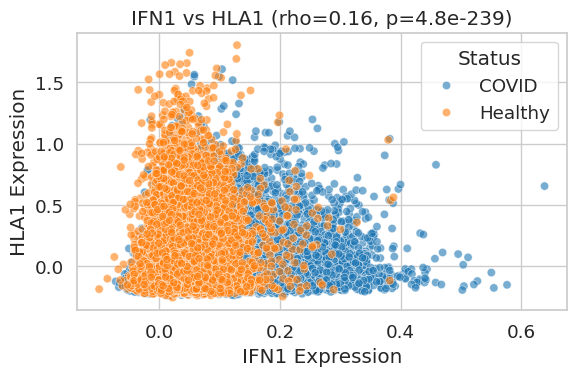

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Extract the relevant metadata from the anndata object
meta_df = adata.obs[['Status', 'cell_type_coarse', 'IFN1', 'HLA1']].copy()

# Compute global Spearman correlation between IFN1 and HLA1 across all cells
rho_global, pval_global = spearmanr(meta_df['IFN1'], meta_df['HLA1'])
print('Global Spearman correlation between IFN1 and HLA1:')
print(f'  rho = {rho_global:.3f}, p-value = {pval_global:.3e}')

# Create a scatter plot of IFN1 vs HLA1 colored by Status
def plot_global_correlation(df):
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x='IFN1', y='HLA1', hue='Status', alpha=0.6)
    plt.title(f'IFN1 vs HLA1 (rho={rho_global:.2f}, p={pval_global:.1e})')
    plt.xlabel('IFN1 Expression')
    plt.ylabel('HLA1 Expression')
    plt.tight_layout()
    plt.show()

plot_global_correlation(meta_df)

# Note: Further steps will involve stratifying by cell_type_coarse and Status to compute subgroup-specific correlations and generate a grid of plots.

## Step 2: Subset the anndata object to identify the relevant cell populations based on 'cell_type_coarse': monocytes (value 3) and T cells (value 1). Extract the expression values for the inflammatory ligands (TNF, IL1B, IL6) in monocytes and the receptors (TNFRSF1A, IL1R1, IL6R) in T cells, while performing sanity checks on cell counts to ensure sufficient representation per group.

Number of cells used for analysis: 44721
Global Spearman correlation between IFN1 and HLA1:
  rho = 0.155, p-value = 4.837e-239


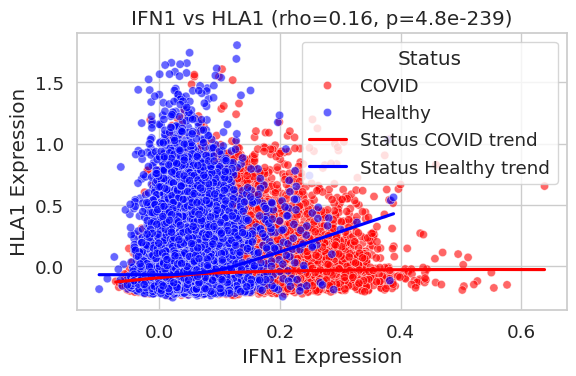

Number of monocytes: 11687
Number of T cells: 0


In [3]:
#!/usr/bin/env python
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy.sparse import issparse
import warnings

# ----- Section 1: Global correlation of IFN1 vs HLA1 -----

# Check that the required columns exist in adata.obs
required_cols = {'Status', 'cell_type_coarse', 'IFN1', 'HLA1'}
if not required_cols.issubset(adata.obs.columns):
    missing = required_cols - set(adata.obs.columns)
    raise ValueError(f"Missing required columns in adata.obs: {missing}")

# Extract the relevant metadata
meta_df = adata.obs[['Status', 'cell_type_coarse', 'IFN1', 'HLA1']].copy()

# Check for NaN values in the IFN1 and HLA1 columns
if meta_df[['IFN1', 'HLA1']].isnull().any().any():
    print("Warning: NaN values detected in IFN1 or HLA1; consider handling missing values before proceeding.")

# Log the number of cells used in the analysis
num_cells = meta_df.shape[0]
print(f"Number of cells used for analysis: {num_cells}")

# Compute global Spearman correlation between IFN1 and HLA1 across all cells
rho_global, pval_global = spearmanr(meta_df['IFN1'], meta_df['HLA1'])
print('Global Spearman correlation between IFN1 and HLA1:')
print(f'  rho = {rho_global:.3f}, p-value = {pval_global:.3e}')

# Define a reusable color mapping for Status groups.
color_mapping = {'COVID': 'red', 'Healthy': 'blue'}

def plot_global_correlation(df):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x='IFN1', y='HLA1', hue='Status', alpha=0.6, palette=color_mapping)
    for status in sorted(df['Status'].unique()):
        subset = df[df['Status'] == status]
        sns.regplot(x='IFN1', y='HLA1', data=subset, scatter=False,
                    label=f'Status {status} trend', color=color_mapping.get(status, 'gray'), lowess=True)
    plt.title(f'IFN1 vs HLA1 (rho={rho_global:.2f}, p={pval_global:.1e})')
    plt.xlabel('IFN1 Expression')
    plt.ylabel('HLA1 Expression')
    plt.legend(title='Status')
    plt.tight_layout()
    plt.show()

plot_global_correlation(meta_df)

# ----- Section 2: Ligand-Receptor Correlation Analysis by Cell Type -----

# Define ligand and receptor pairs
ligands = ['TNF', 'IL1B', 'IL6']
receptors = ['TNFRSF1A', 'IL1R1', 'IL6R']
assert len(ligands) == len(receptors), "The number of ligands and receptors must be equal."

def check_genes_in_adata(genes, adata_obj):
    missing_genes = [g for g in genes if g not in adata_obj.var_names]
    if missing_genes:
        msg = f"The following genes are missing in adata.var_names: {missing_genes}. Please review the dataset or update the gene list."
        warnings.warn(msg)
        raise ValueError(msg)

check_genes_in_adata(ligands + receptors, adata)

# Use string matching for cell type labels (case-insensitive).
monocyte_mask = adata.obs['cell_type_coarse'].str.contains('monocyte', case=False, na=False)
tcell_mask = adata.obs['cell_type_coarse'].str.contains('t cell', case=False, na=False)

monocytes = adata[monocyte_mask]
t_cells = adata[tcell_mask]

print(f"Number of monocytes: {monocytes.n_obs}")
print(f"Number of T cells: {t_cells.n_obs}")

if monocytes.n_obs == 0 or t_cells.n_obs == 0:
    warnings.warn("No monocytes or T cells found in the dataset. Skipping ligand-receptor correlation analysis.")
else:

    def compute_average_expression(adata_subset, gene_list):
        if adata_subset.n_obs == 0:
            warnings.warn("No cells in the selected subset. Returning an empty DataFrame.")
            return pd.DataFrame()
        expr_df = pd.DataFrame()
        expr_df['Donor'] = adata_subset.obs['Donor_full']
        expr_df['Status'] = adata_subset.obs['Status']
        for gene in gene_list:
            expr = adata_subset[:, gene].X
            if issparse(expr):
                expr = expr.toarray().flatten()
            else:
                expr = np.array(expr).flatten()
            if expr.size == 0:
                raise ValueError(f"No expression data found for gene {gene}.")
            expr_df[gene] = expr
        for col in gene_list:
            if not pd.api.types.is_numeric_dtype(expr_df[col]):
                raise TypeError(f"Expression data for {col} is not numeric.")
        avg_expr = expr_df.groupby(['Donor', 'Status'], as_index=False).mean()
        donor_counts = avg_expr.groupby('Status').size()
        print(f"Donor counts per Status group:\n{donor_counts}")
        return avg_expr

    mono_avg = compute_average_expression(monocytes, ligands)
    tcell_avg = compute_average_expression(t_cells, receptors)

    merged_avg = pd.merge(mono_avg, tcell_avg, on=['Donor', 'Status'], suffixes=('_mono', '_tcell'))

    correlation_results = {}

    print('Global Spearman correlations for ligand (monocytes) vs receptor (T cells):')
    for ligand, receptor in zip(ligands, receptors):
        x = merged_avg[f'{ligand}_mono']
        y = merged_avg[f'{receptor}_tcell']
        rho, pval = spearmanr(x, y)
        correlation_results[f'{ligand}-{receptor}'] = {
            'global_rho': rho, 
            'global_pval': pval, 
            'n_donors': merged_avg.shape[0]
        }
        print(f'  {ligand} (monocytes) vs {receptor} (T cells): rho = {rho:.3f}, p-value = {pval:.3e}')

    stratified_results = {}
    for status in sorted(merged_avg['Status'].unique()):
        strat_df = merged_avg[merged_avg['Status'] == status]
        if len(strat_df) < 3:
            warnings.warn(f"Low donor count for Status {status}: {len(strat_df)} donor(s) may limit robust correlation estimation.")
        stratified_results[status] = {}
        print(f'\nStatus {status}:')
        for ligand, receptor in zip(ligands, receptors):
            x = strat_df[f'{ligand}_mono']
            y = strat_df[f'{receptor}_tcell']
            if len(strat_df) > 1:
                rho, pval = spearmanr(x, y)
            else:
                rho, pval = (np.nan, np.nan)
            stratified_results[status][f'{ligand}-{receptor}'] = {
                'rho': rho, 
                'pval': pval, 
                'n_donors': len(strat_df)
            }
            pval_disp = f"{pval:.1e}" if not np.isnan(pval) else "NA"
            print(f'  {ligand} (monocytes) vs {receptor} (T cells): rho = {rho:.3f}, p-value = {pval_disp}')

    n_pairs = len(ligands)
    fig, axes = plt.subplots(n_pairs, 2, figsize=(12, 4 * n_pairs))
    for i, (ligand, receptor) in enumerate(zip(ligands, receptors)):
        ax_all = axes[i, 0]
        sns.regplot(x=merged_avg[f'{ligand}_mono'], y=merged_avg[f'{receptor}_tcell'], 
                    ax=ax_all, scatter_kws={'s': 50, 'alpha': 0.7})
        rho_all = correlation_results[f'{ligand}-{receptor}']['global_rho']
        p_all = correlation_results[f'{ligand}-{receptor}']['global_pval']
        ax_all.annotate(f'ρ = {rho_all:.2f}\np = {p_all:.1e}', 
                        xy=(0.05, 0.90), xycoords='axes fraction', fontsize=10,
                        bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3))
        ax_all.set_title(f'Overall: {ligand} (monocytes) vs {receptor} (T cells)')
        ax_all.set_xlabel(f'Avg {ligand} Expression (Monocytes)')
        ax_all.set_ylabel(f'Avg {receptor} Expression (T cells)')
        
        ax_strat = axes[i, 1]
        statuses = sorted(merged_avg['Status'].unique())
        for idx, status in enumerate(statuses):
            strat_df = merged_avg[merged_avg['Status'] == status]
            sns.regplot(x=strat_df[f'{ligand}_mono'], y=strat_df[f'{receptor}_tcell'], 
                        label=f'Status {status}', ax=ax_strat, scatter_kws={'s': 50, 'alpha': 0.7})
            if len(strat_df) > 1:
                temp_rho, temp_p = spearmanr(strat_df[f'{ligand}_mono'], strat_df[f'{receptor}_tcell'])
                xpos = 0.05 if idx % 2 == 0 else 0.65
                ax_strat.annotate(f'Status {status}: ρ={temp_rho:.2f}\np={temp_p:.1e}', 
                                  xy=(xpos, 0.90 - 0.1 * idx), xycoords='axes fraction', fontsize=9,
                                  bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))
        ax_strat.set_title(f'Stratified by Status: {ligand} vs {receptor}')
        ax_strat.set_xlabel(f'Avg {ligand} Expression (Monocytes)')
        ax_strat.set_ylabel(f'Avg {receptor} Expression (T cells)')
        ax_strat.legend()
    
    plt.tight_layout()
    plt.show()